#### November 20th: 
#### Color coded histo, added noise level to dataframe
#### Issue creating differences plot; however, I am almost certain there is no difference. Printed differences which come out to 0
#### When I change the sn_masked to compressed from the onset, I get Index OOB errors
#### What is meant by slicing by richness and z?
#### How to filter noises to get only valid data?
#### Still not confident on wtf compressing does
#### Why isn't there any change as a result of changing the bad val?
#### Have yet to really get around to reading khatri paper

### Import necessary shit

In [32]:
# Import libraries
# Ignore warnings
import numpy as np
from scipy.stats import norm
import numpy as np
import astropy
import astropy_healpix
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
import healpy as hp
import pandas as pd
import math
import scipy
import statistics as st
from scipy import stats
import matplotlib
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from IPython.display import Image

%matplotlib inline

NSIDE=2048
Npix=12*NSIDE**2

pi=math.pi

import warnings
warnings.filterwarnings('ignore')

### Read in data

In [33]:
# Read in AMF catalog
dr9 = pd.read_csv('Data/dr9_main_complete.csv', header=-1)
dr9.columns = ['amf_no','amf_ra','amf_dec','amf_z','amf_lk','amf_rh','amf_r200','amf_rc','amf_c','amf_str_rh','bax_id','mcxc_id','red_id','whl_id']
#dr9.head()
dr9.shape

(46479, 14)

In [34]:
# Read in Burenin catalog
bur = pd.read_csv('Data/planck_extended_burenin.csv')
#bur.head()
bur.shape

(2964, 5)

In [35]:
# Read in Redmapper catalog
red = pd.read_csv("Data/redmapper_v6.3_errs.csv",header=-1)
red.columns = ['red_no','red_ra','red_dec','red_z','red_zerr','red_rh','red_rherr']
#red.head()
red.shape

(26111, 7)

In [36]:
# Read in Planck catalog
plsz2 = pd.read_csv('Data/planck_sz2.csv',header=-1)
plsz2.columns = ['pl_no','pl_name','pl_glon','pl_glat','pl_ra','pl_dec','pl_poserr','pl_sn',\
                   'pl_pipe','pl_pipedet','pl_pccs2','pl_psz','pl_irflag','pl_qneural','pl_y5r500',\
                   'pl_y5r500err','pl_valid','pl_zid','pl_z','pl_msz','pl_mszerrup','pl_mszerrlow',\
                   'pl_mcxc','pl_red','pl_act','pl_spt','pl_wise','pl_ami','pl_cosmo','pl_comment']
#plsz2.head()
plsz2.shape

(1653, 30)

In [37]:
# Read in ymaps, stddevs (in Galactic coordinates)
nilc_ymap = hp.read_map('Data/COM_CompMap_Compton-SZMap-nilc-ymaps_2048_R2.00.fits')
nilc_stddevmap = hp.read_map('Data/COM_CompMap_Compton-SZMap-nilc-stddev_2048_R2.00.fits')

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


### Catalogs

In [38]:
# Convert the RA and DEC to galactic coordinates
c = SkyCoord(dr9['amf_ra'],dr9['amf_dec'],frame='icrs',unit='deg')

dr9['glat'] = c.galactic.b.degree
dr9['glon'] = c.galactic.l.degree

c=SkyCoord(bur['bur_ra'],bur['bur_dec'],frame='icrs',unit='deg')

bur['glat'] = c.galactic.b.degree # Galactic Latitude
bur['glon'] = c.galactic.l.degree # Galactic Longitude

In [39]:
bur.head()

bur_no  bur_dec  bur_ra   bur_z  bur_sn       glat        glon
0       1  29.1144  0.2000  0.1928    4.58 -32.464350  109.815588
1       2  21.5636  0.2958  0.4110    7.77 -39.813384  107.662070
2       3  -0.0147  0.3500  0.2479    4.55 -60.339963   96.974176
3       4  12.0578  0.5042  0.1989    9.52 -49.020180  104.324479
4       5  -1.0683  0.7042  0.7600    4.99 -61.448190   96.797899

In [40]:
dr9.head()
    pix = hp.ang2pix(2048,dr9.iloc[j,15],dr9.iloc[j,14],lonlat=True,nest=False)


amf_no    amf_ra  amf_dec   amf_z    amf_lk    amf_rh  amf_r200  amf_rc  \
0       4   23.9128  20.7465  0.0601  176.9125  219.3663     1.946   0.925   
1       5  260.6324  32.1398  0.2252  222.1219  200.7117     1.784   0.625   
2       6  197.8796  -1.3356  0.2042  171.6872  192.0829     1.773   0.227   
3       7  250.1485  46.6917  0.2248  225.9874  182.3373     1.725   0.495   
4       8  346.3402  21.0378  0.1453  121.0124  182.2769     1.775   0.440   

   amf_c  amf_str_rh     bax_id       mcxc_id                red_id  \
0  2.104     73.0001      -9999         -9999                 -9999   
1  2.856     35.0001  ABELL2261  J1722.4+3208  RMJ172227.2+320757.2   
2  7.792      9.0001  ABELL1689  J1311.5-0120  RMJ131129.5-012028.0   
3  3.483     36.0001  ABELL2219  J1640.3+4642  RMJ164019.8+464241.5   
4  4.034     72.0001      -9999         -9999  RMJ230520.1+210313.5   

             whl_id       glat        glon  
0             -9999 -40.943468  136.662636  
1  J172227.2+320757  31.846666   55.602221  
2  J131129.5-012028  61.128514  313.370385  
3  J164019.8+464242  41.429880   72.599428  
4  J230520.1+210313 -35.420653   92.175825

### Create masked map

Found Burenin filter (https://healpix.jpl.nasa.gov/html/subroutinesnode48.htm) but it's in fucking fortran

In [41]:
# Smooth noise map by 1 degree
# The essential difference between Burenin and this, is that he uses
# a 1 degree radius median filter for smoothing (not available on healpy)
stddev_smoothed = hp.smoothing(nilc_stddevmap,fwhm=np.radians(2.))

Sigma is 50.959308 arcmin (0.014823 rad) 
-> fwhm is 120.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [42]:
# Calculate signal over noise (smoothed)
sn_smoothed_n = nilc_ymap/stddev_smoothed

# Smooth the sn_smoothed_n map by 1 degree
sn_smoothed_n_smoothed = hp.smoothing(sn_smoothed_n,fwhm=np.radians(1.))

# Subtract the smoothed signal to noise map from the signal to noise map
sn_result = sn_smoothed_n - sn_smoothed_n_smoothed

Sigma is 25.479654 arcmin (0.007412 rad) 
-> fwhm is 60.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [43]:
# Mask the sn_result array
# By convention the mask is 0 where the data is masked, while numpy defines data masked when 
# the mask is true, so it is necessary to flip the mask.
mask = hp.read_map('Data/maskplanckfullsz61.fits')
sn_masked = hp.ma(sn_result,badval=+1.6375e+30)
sn_masked2 = hp.ma(sn_result)
sn_masked2.mask = np.logical_not(mask)
sn_masked.mask = np.logical_not(mask)

NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [44]:
scipy.stats.describe(mask)

DescribeResult(nobs=50331648, minmax=(0.0, 1.0), mean=0.6119134624799093, variance=0.23747538163398552, skewness=-0.4593069694500196, kurtosis=-1.7890371078147336)

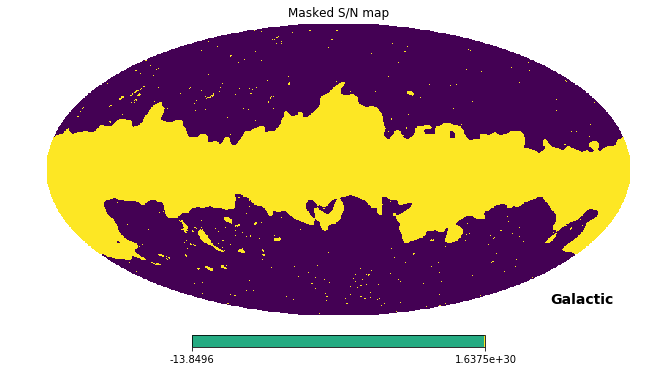

In [45]:
# Plot the masked array
hp.mollview(sn_masked,norm='hist',coord=['G'],title='Masked S/N map')

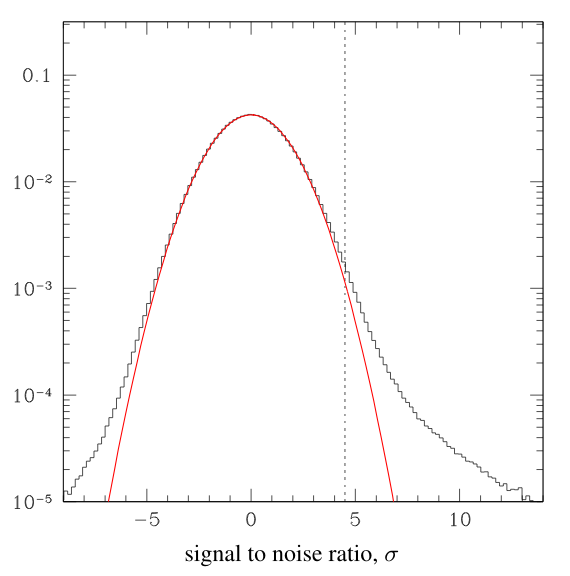

In [46]:
Image(filename='Papers/burfig.png') 

#### Burenin Plot

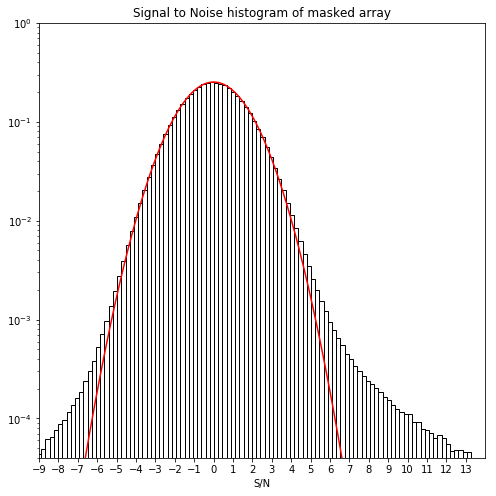

In [47]:
# Histogram of the above map
plt.figure(figsize=(8,8))
plt.hist(sn_masked.compressed(), bins=500,normed=True,fill=False,edgecolor='k');
plt.xlim((-9,14))
plt.ylim((4e-5,1))
plt.yscale('log');
plt.xticks(np.arange(-9, 14, 1.0))
plt.xlabel('S/N');
plt.title('Signal to Noise histogram of masked array')

ln = np.linspace(-9, 14, len(sn_masked))
g = stats.norm.pdf(ln, 0, 1.58)  
plt.plot(ln, g, label="Norm", color="red")

plt.show()

#### Differences Plot

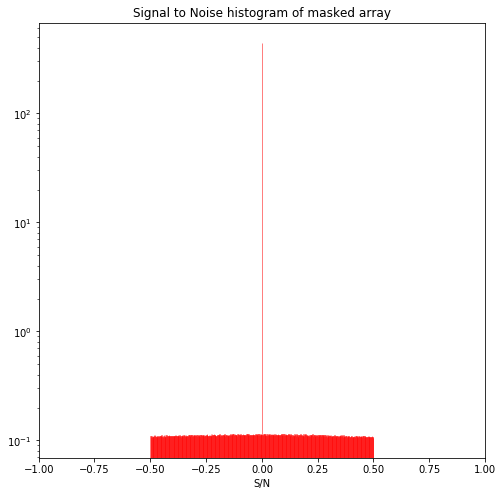

In [48]:
# Histogram of the above map
sn_masked3 = sn_masked2-sn_masked
plt.figure(figsize=(8,8))
plt.hist(sn_masked3, bins=500,normed=True,fill=False,edgecolor='r', alpha = 0.5);
# plt.hist(sn_masked2, bins=500,normed=True,fill=False,edgecolor='b', alpha = 0.5);
plt.yscale('log');
plt.xlabel('S/N');
plt.xlim((-1,1))
plt.title('Signal to Noise histogram of masked array')

plt.show()

In [49]:
print(sn_masked3)

[0.0 0.0 0.0 ... 0.0 0.0 0.0]


In [50]:
scipy.stats.describe(sn_masked)

DescribeResult(nobs=50331648, minmax=(-1473.5981054323968, 1650.3349078145095), mean=-6.636043488053242e-09, variance=10.11485622718682, skewness=-4.217014382600839, kurtosis=13500.95089301354)

In [51]:
scipy.stats.describe(sn_masked2)

DescribeResult(nobs=50331648, minmax=(-1473.5981054323968, 1650.3349078145095), mean=-6.636043488053242e-09, variance=10.11485622718682, skewness=-4.217014382600839, kurtosis=13500.95089301354)

#### Test Plot

(60, 80)

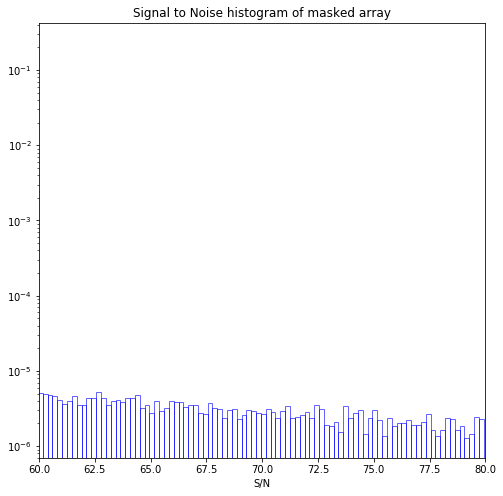

In [52]:
# Histogram of the above map
plt.figure(figsize=(8,8))
pl1 = plt.hist(sn_masked, bins=500,normed=True,fill=False,edgecolor='b', alpha = 0.6);
# pl2 = plt.hist(sn_masked2, bins=500,normed=True,fill=False,edgecolor='r', alpha = 0.6);

plt.yscale('log');
# plt.xticks(np.arange(-9, 14,5))
plt.xlabel('S/N');
plt.title('Signal to Noise histogram of masked array')
plt.xlim((60,80))

# ln = np.linspace(-9, 14, len(sn_masked))
# g = stats.norm.pdf(ln, 0, 1.81)  
# plt.plot(ln, g, label="Norm", color="red")

# plt.show()

In [53]:
stats.kstest(ln, 'norm')
# print(stats.ttest_ind(,))

KstestResult(statistic=0.49952827984735115, pvalue=0.0)

### Locate unclassified AMF clusters

#### AMF rounded

In [54]:
d_glonR = []
d_glatR = []
d_glon = []
d_glat = []
d_rh = []

for i in range(dr9.shape[0]):
#     if dr9.iloc[i,5] > 50:   #Why does the SN plot change when I apply this?
#     if dr9.iloc[i,3] > 0.3:   #Why does the SN plot change when I apply this?
        d_glon.append(dr9.iloc[i,15])
        d_glat.append(dr9.iloc[i,14])
        d_glonR.append("%.1f" % dr9.iloc[i,15])
        d_glatR.append("%.1f" % dr9.iloc[i,14])

tup1 = zip(d_glon, d_glat)
  
df1 = pd.DataFrame({'Glon': d_glon, 'Glat': d_glat})
df2 = pd.DataFrame({'Glon': d_glonR, 'Glat': d_glatR})

#### Burenin rounded

In [55]:
b_glon = []
b_glat = []
b_rh = []

for i in range(bur.shape[0]):
        b_glon.append("%.1f" % bur.iloc[i,6])
        b_glat.append("%.1f" % bur.iloc[i,5])

tup2 = zip(b_glon, b_glat)

df3 = pd.DataFrame({'Glon': b_glon, 'Glat': b_glat})
df3.shape

(2964, 2)

#### Find AMF unique clusters

In [56]:
a = set(list(zip(d_glonR, d_glatR)))
b = set(list(zip(b_glon, b_glat)))
c = a-b
d,e, = zip(*c)
len(c)

45589

In [57]:
new = pd.DataFrame({'Glon': d, 'Glat': e})
new.head()

Glon   Glat
0  251.8   76.1
1   90.4  -29.0
2   54.6   30.0
3  127.3  -69.2
4  116.0  -50.8

#### Find AMF clusters with high SNs (>7)

In [58]:
num = []
highglon = []
highglat = []
indx = []

for j in range(dr9.shape[0]):
    pix = hp.ang2pix(2048,dr9.iloc[j,15],dr9.iloc[j,14],lonlat=True,nest=False)
    if sn_masked[pix] > 7:
        highglon.append("%.1f" % dr9.iloc[j,15])
        highglat.append("%.1f" % dr9.iloc[j,14])
        num.append(dr9.iloc[j,0])
        indx.append(j)

tup3 = zip(highglon, highglat)

df4 = pd.DataFrame({'Glon': highglon, 'Glat': highglat})

#### Generate counts for clusters identified and unidentified by Burenin

Re-wrote all the following code because old code was fucked up. Converted the AMF and Burenin catalogs to sets of tuples (glon,glat) and then subtracted Burenin from AMF to get the AMF-unique clusters. May have lost some precision by rounding the glon and glat to one dec but by using *both* glon and glat I'm hoping that there won't be any errors in subtraction.

In [59]:
f = set(list(zip(highglon, highglat)))
g = f-b
h = f-g
len(h)

i,j = zip(*h)
k,l = zip(*g)
m,n = zip(*f)

inbur = pd.DataFrame({'Glon': i, 'Glat': j})
notinbur = pd.DataFrame({'Glon': k, 'Glat': l})
total = pd.DataFrame({'Glon': m, 'Glat': n})
print("Known clusters: ", df3.shape[0])
print("Newly identified clusters: ", notinbur.shape[0])

Known clusters:  2964
Newly identified clusters:  170


#### Create list of cluster numbers

In [60]:
%%time

clusts = []
RA = []
dec = []
lat = []
lon = []
sn = []
z = []
rich = []
burn = []
noi = []

for i in range(inbur.shape[0]):
    for j in range(dr9.shape[0]):
        if(inbur.iloc[i,0] == "%.1f" % dr9.iloc[j,15]) and (inbur.iloc[i,1] == "%.1f" % dr9.iloc[j,14]):
            pix = hp.ang2pix(2048,dr9.iloc[j,15],dr9.iloc[j,14],lonlat=True)
            
            noi.append(nilc_stddevmap[pix])
            clusts.append(dr9.iloc[j,0])
            RA.append(dr9.iloc[j,1])
            dec.append(dr9.iloc[j,2])
            lat.append(dr9.iloc[j,14])
            lon.append(dr9.iloc[j,15])
            sn.append(sn_masked[pix])
            z.append(dr9.iloc[j,3])
            rich.append(dr9.iloc[j,5])
            burn.append(1)

for k in range(notinbur.shape[0]):
    for l in range(dr9.shape[0]):
        if(notinbur.iloc[k,0] == "%.1f" % dr9.iloc[l,15]) and (notinbur.iloc[k,1] == "%.1f" % dr9.iloc[l,14]):
            pix = hp.ang2pix(2048,dr9.iloc[l,15],dr9.iloc[l,14],lonlat=True)
            
            noi.append(nilc_stddevmap[pix])
            clusts.append(dr9.iloc[l,0])
            RA.append(dr9.iloc[l,1])
            dec.append(dr9.iloc[l,2])
            lat.append(dr9.iloc[l,14])
            lon.append(dr9.iloc[l,15])
            sn.append(sn_masked[pix])
            z.append(dr9.iloc[l,3])
            rich.append(dr9.iloc[l,5])
            burn.append(0)        

final = pd.DataFrame({'no': clusts, 'ra': RA, 'dec': dec, 'glat': lat, 'glon': lon, 'sn': sn, 'z': z, 'rh': rich, 'bur': burn, 'noi': noi})

CPU times: user 3min 29s, sys: 43.4 ms, total: 3min 29s
Wall time: 3min 30s


In [61]:
final[(final.rh > 50) & (final.noi > 0)].sort_values(by=['sn'], ascending = False)

no        ra      dec       glat        glon         sn       z  \
256   587  258.1058  64.0520  34.964831   93.928116  55.194766  0.0827   
236     7  250.1485  46.6917  41.429880   72.599428  44.674799  0.2248   
120    22  328.4102  17.6964 -27.818081   73.966452  31.827315  0.2733   
54    401  130.7422  36.3575  37.265469  186.370135  31.361665  0.2999   
158     6  197.8796  -1.3356  61.128514  313.370385  31.143056  0.2042   
71    169  216.4957  37.8322  67.462893   67.224236  29.542457  0.1669   
251  1381   10.4474  -9.3602 -72.086443  115.172861  29.512361  0.0565   
221    18  203.8354  41.0006  73.444772   92.647549  28.961685  0.2365   
46     10  203.1873  50.5346  65.305106  107.103759  25.696075  0.3110   
320     5  260.6324  32.1398  31.846666   55.602221  24.655148  0.2252   
312  1689  227.5324  33.4691  59.546357   53.491427  22.761302  0.1171   
74   1646  255.6736  34.0653  36.317169   56.792459  22.758043  0.0974   
274   227  239.6198  27.3433  48.677997   44.403436  21.894399  0.0903   
245    57  210.2728   2.9235  60.616101  340.458271  21.863032  0.2527   
67     13  139.4938  51.7236  43.387615  166.090009  20.839521  0.2574   
32    186  332.9356  -3.8274 -45.352606   57.260291  20.449467  0.3965   
293  2011  164.5159  56.7934  54.144838  149.284517  20.063093  0.1364   
22   1505  194.6729  -1.7615  61.057456  306.679465  19.915610  0.0828   
191   963  178.8439  23.3474  76.779712  226.454947  19.375082  0.1392   
34    117  330.2229  20.9783 -26.620944   77.904557  19.352708  0.1765   
58    856  260.0196  26.6485  30.882232   49.239338  19.314747  0.1601   
73     36   14.0123  26.3806 -36.479647  124.216377  19.258108  0.2266   
37    359  230.6003  27.7122  56.627220   42.839435  19.212283  0.0741   
123  1205  257.4520  34.4230  34.942320   57.569548  19.134240  0.0857   
84    382  179.8410  49.7930  65.231563  143.242258  18.588438  0.3488   
14    106  198.7957  51.8164  64.910207  114.260216  18.586359  0.2822   
53     42  180.3486  23.1085  77.987637  229.728375  18.265236  0.2615   
280   104  189.2712  63.2056  53.846196  125.673017  17.428501  0.3022   
94    495  231.0557  29.9294  56.477398   46.918269  17.265701  0.1185   
160   149  177.4175  22.3998  75.215548  228.203681  16.985604  0.5036   
..    ...       ...      ...        ...         ...        ...     ...   
57   1412  339.5864  26.6340 -27.433506   89.389764   7.412097  0.3177   
76   1301  208.4847  14.8974  70.999751  356.012992   7.402435  0.1262   
283  1738  234.9935  17.9318  50.203760   28.657341   7.395138  0.3870   
264   743  261.8921  61.4860  33.552605   90.595642   7.363401  0.3123   
297   173  144.1942  12.4975  42.263764  220.809597   7.347487  0.3341   
106  1056  337.2132   7.4593 -41.140986   72.819946   7.333455  0.3686   
210    97    4.7465 -20.3422 -79.945643   73.648526   7.316389  0.2860   
301   692  126.1936   4.4784  22.770813  219.819012   7.292077  0.2256   
230   582    7.5003 -20.0745 -81.408051   86.973769   7.239032  0.2487   
322   532  185.5936  40.4934  75.348401  145.281150   7.235299  0.3103   
95    591  221.0751  35.9140  64.504229   60.112026   7.223145  0.3513   
186   844  190.3878  32.8439  83.897211  142.857942   7.216375  0.3946   
263  1022  168.1978   2.4470  55.846942  254.981744   7.208009  0.2651   
1     270  261.8056  70.6090  32.430127  101.395086   7.198512  0.3610   
217  2306  168.1501  -3.1988  51.425374  260.914714   7.182538  0.0980   
161   569  209.7663  27.8486  74.996436   39.586041   7.171548  0.4821   
176   153  356.1347   3.0939 -55.739538   92.238774   7.171373  0.3427   
272  2164  171.7571  17.1291  68.090413  235.700670   7.155957  0.1307   
295   972    2.5854  17.7392 -44.039091  109.262938   7.121250  0.1915   
175   479  229.1847  -0.9078  45.212154    0.151163   7.112825  0.1191   
195    37  186.6912  21.8663  82.308908  254.764071   7.112371  0.4340   
7     408  194.1038   4.6735  67.513891  306.176061   7.077389  0.2321   
126   297  

In [63]:
np.mean(final.noi)

8.933140773374012e-07

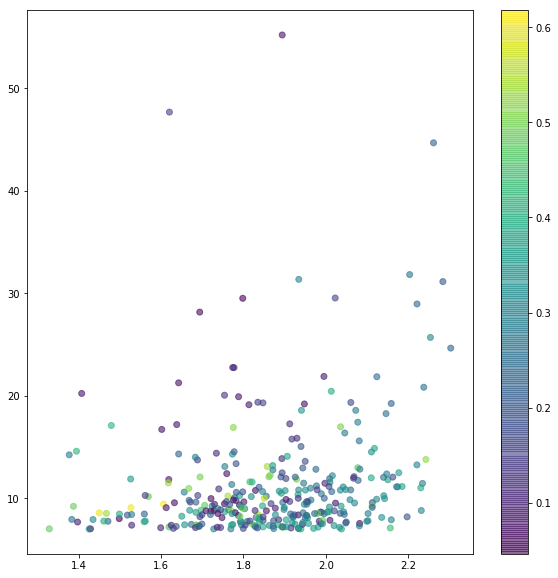

In [66]:
plt.figure(figsize=(10,10))
plt.scatter(np.log10(final['rh']),final['sn'],c=final.z,alpha=.6);
plt.colorbar()

### Plot AMF and compare plots to Burenin

--------------------------------------------------------------------------------------------------------------

In [ ]:
sns = []

for i in range(new.shape[0]):
    pix = hp.ang2pix(2048,float(new.iloc[i,0]),float(new.iloc[i,1]),lonlat=True)
    if sn_masked[pix]:
        sns.append(sn_masked[pix])
        
len(sns)
# sns

In [ ]:
# Histogram of the above map
plt.figure(figsize=(8,8))
plt.hist(sns,bins=500,normed=True,fill=False,edgecolor='blue',alpha=.6);
plt.xlim((-9,14))
plt.ylim(1e-4,)
plt.yscale('log');
plt.xlabel('S/N');
plt.title('Signal to Noise histogram of AMF-unique clusters');

# ln = np.linspace(-9, 14, len(sns))
# g = stats.norm.pdf(ln, 0, 1.73)  
# plt.plot(ln, g, label="Norm", color="red")

plt.show()

In [ ]:
plt.hist(sns,bins=500,normed=True,fill=False,edgecolor='blue',alpha=.6);
plt.hist(sn_masked.compressed(), bins=500,normed=True,fill=False,edgecolor='r',);

plt.xlim((-9,14))
plt.ylim(1e-5,)
plt.yscale('log');
plt.xlabel('S/N');
plt.title('Signal to Noise histogram of masked array');

# ln = np.linspace(-9, 14, len(sn_masked))
# g = stats.norm.pdf(ln, 0, 1.73)  
# plt.plot(ln, g, label="Norm", color="red")

plt.show()

-----------------------------------------------------------------------------------------

### Comparison of AMF to Burenin

Compare SNs given by the smoothing/masking utilized here to Big Burenin's SNs. The fact that 41% of the SNs are greater than 0.5 away leads me to believe I either fucked up or something is wrong with the method.

In [ ]:
c=SkyCoord(bur['bur_ra'],bur['bur_dec'],frame='icrs',unit='deg')

bur['glat'] = c.galactic.b.degree # Galactic Latitude
bur['glon'] = c.galactic.l.degree # Galactic Longitude

bur.head()

In [ ]:
pix = hp.ang2pix(2048,bur.iloc[4,6],bur.iloc[4,5],lonlat=True)

In [ ]:
sn_masked[pix]

In [ ]:
cnt1 = 0
for i in range(bur.shape[0]):
    pix = hp.ang2pix(2048,bur.iloc[i,6],bur.iloc[i,5],lonlat=True)
    if sn_masked[pix]-bur.iloc[i,4] > 0.5 or sn_masked[pix]-bur.iloc[i,4] < -0.5:
        cnt1 += 1
print(cnt1/bur.shape[0])

In [ ]:
arr = []
for j in range(bur.shape[0]):
    pix = hp.ang2pix(2048,bur.iloc[j,6],bur.iloc[j,5],lonlat=True)
    arr.append(abs(sn_masked[pix]-bur.iloc[j,4]))

print(st.median(arr))
print(st.mean(arr))
print(st.stdev(arr))

------------------------------------------------------------------------------------------------------------------- 

### Test/example code for reference

In [ ]:
# Print amf catalog for reference
dr9.head()

In [ ]:
# Example of conversion to galactic coordinates
print(hp.ang2pix(2048,139.22360248447205,56.42252190720151,lonlat=True))
sn_masked[4198545]
print(hp.pix2ang(NSIDE,4198545,lonlat=True,nest=False))

In [ ]:
# Define functions to convert dec and ra to pixel vals and vice versa
def DeclRaToIndex(decl,RA):
    return hp.ang2pix(NSIDE,np.deg2rad(90.0-decl),np.deg2rad(RA),lonlat=False,nest=False)
# Define a function to convert index to dec, ra
def IndexToDeclRa(index):
    theta,phi=hp.pix2ang(NSIDE,index,lonlat=False,nest=False)
    return -np.degrees(theta-pi/2.),np.degrees(pi*2.-phi)
def DeclRaToIndex_8neighbors(decl,RA):
    return hp.get_all_neighbours(NSIDE,np.radians(90.0-decl),np.radians(360.0-RA),lonlat=False,nest=False)

In [ ]:
# Using method from Burenin-6 ***WRONG***
testpix1 = DeclRaToIndex(32.1398,260.6324)
print(testpix1)

# Using method from sample code ***CORRECT***
testpix2 = hp.ang2pix(2048,55.602221,31.846666,lonlat=True)
print(testpix2)